# Import Modules

In [2]:
import pandas as pd
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from langdetect import detect
import matplotlib.pyplot as plt
import emoji.unicode_codes
import swifter
import emoji

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\tomev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fetch Dataset

In [151]:
#current directory containing dataset
directory = "Dataset/"

#read training set
train_csv = pd.read_csv(directory+"mediaeval-2015-trainingset.txt", sep="\t", quoting=3)
train_df = pd.DataFrame(data = train_csv)

#read test set
test_csv = pd.read_csv(directory+"mediaeval-2015-testset.txt", sep="\t", quoting=3)
test_df = pd.DataFrame(data = test_csv)

# Data Characterisation

Initial investigation into dataset, preparing it for analysis and processing

In [152]:
#Dataset information, mainly different fields and size
train_df.info()
print()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  int64 
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  int64 
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   timestamp   14483 non-null  object
 6   label       14483 non-null  object
dtypes: int64(2), object(5)
memory usage: 792.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3781 non-null   int64 
 1   tweetText   3781 non-null   object
 2   userId      3781 non-null   int64 
 3   imageId(s)  3781 non-null   object
 4   username    3781 non-null   object
 5   timestamp   3781 non-null   object
 6   label       3781 non-null   object
dtypes: int64

In [22]:
#shape of training/test sets
print(train_df.shape)
print(test_df.shape)

(14483, 7)
(3781, 7)


In [153]:
#inspect the training set
display(train_df)

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...
14478,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
14479,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
14480,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
14481,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [30]:
#inspect the test set
display(test_df)

,tweetId,tweetText,userId,imageId,username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Mar 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Mar 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Mar 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Mar 2015,fake
4,578975333841551360,"""@ebonfigli: Éclipse vue de l'ISS... Autre cho...",1150728872,eclipse_01,Epimethee_,Mar 2015,fake
...,...,...,...,...,...,...,...
3776,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Mar 2015,fake
3777,578433646597656576,"Oh les kleine menteurs ""@CorineBarella: Un pré...",27575883,varoufakis_1,damomarc,Mar 2015,fake
3778,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Mar 2015,fake
3779,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Mar 2015,fake


In [154]:
#replace 'humor' label with 'fake'
train_df['label'] = train_df['label'].replace('humor', 'fake')
test_df['label'] = test_df['label'].replace('humor', 'fake')

In [155]:
#renaming ImageId(s) as clunky column name
train_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)
test_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)

In [156]:
#strip time stamp to just name and month

def strip_time(text):
    words = text.split()
    month_year = words[1] + ' ' + words[-1]
    return month_year

train_df["timestamp"] = train_df["timestamp"].apply(strip_time)
test_df["timestamp"] = test_df["timestamp"].apply(strip_time)


In [181]:
#Searching for duplicate tweets in training
print(train_df["tweetText"].describe())
print(f"duplicates:  {train_df['tweetText'].duplicated().sum()}")


#Searching for duplicate tweets in test
print(test_df["tweetText"].describe())
print(f"duplicates:  {test_df['tweetText'].duplicated().sum()}")

count                                                 10544
unique                                                10544
top       ¿Se acuerdan de la película: “El día después d...
freq                                                      1
Name: tweetText, dtype: object
duplicates:  0
count                                                  3781
unique                                                 3730
top       J'aime une vidéo @YouTube : "SYRIA! SYRIAN HER...
freq                                                      4
Name: tweetText, dtype: object
duplicates:  51


# Data Analysis

Analysing data quality and bias. As well as patterns and trends in relation with the data labels Real and Fake.

Train:


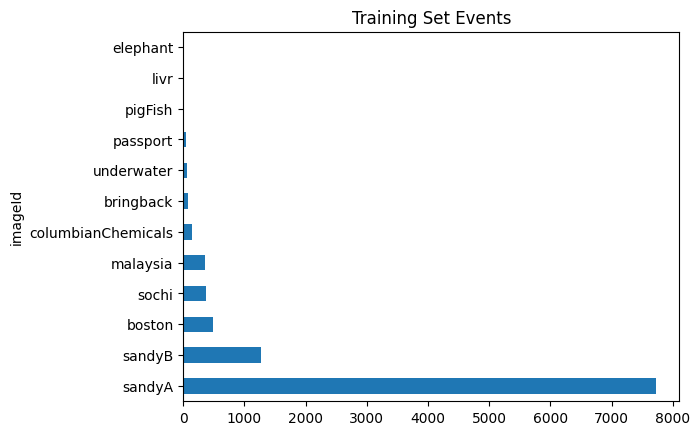

In [183]:
#events categorised by ImageID (train)
selected_events = train_df["imageId"].str.split('_').str[0].value_counts()
selected_events.plot(kind="barh")
plt.title("Training Set Events")
plt.show()



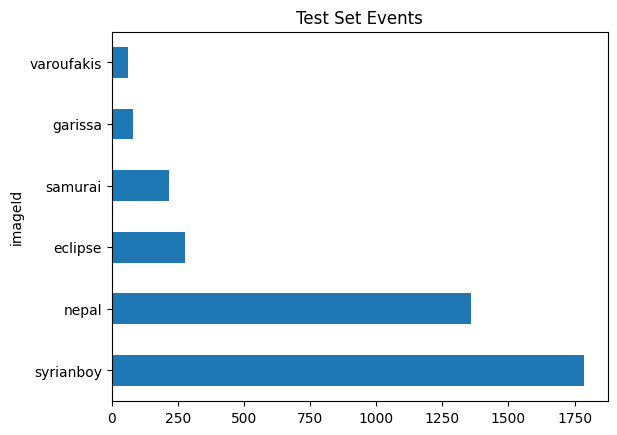

In [184]:
#events categorised by ImageID (test)
selected_events = test_df["imageId"].str.split('_').str[0].value_counts()
selected_events.plot(kind="barh")
plt.title("Test Set Events")
plt.show()

In [189]:
#example tweets for different events
event = "sandy" #change variable for different events
total_df = train_df + test_df
display(total_df[total_df["imageId"].str.contains(event, na=False)]["tweetText"])


0       ¿Se acuerdan de la película: “El día después d...
1       @milenagimon: Miren a Sandy en NY!  Tremenda i...
2       Buena la foto del Huracán Sandy, me recuerda a...
3       Scary shit #hurricane #NY http://t.co/e4JLBUfH...
4       My fave place in the world #nyc #hurricane #sa...
                              ...                        
3757    #holyshit #unreal #sandy http://t.co/mSQAQHLQZ...
3769    Heheeeheheheh RT @CarlaNicoll: Hahahahah :p #S...
3771    #Sandy #Brooklyn Bridge  #HurricaneSandy http:...
3777    вносим позитивную волну в ленту по поводу США ...
3779    Escalofriante “@jrcisneross: Tiburones por las...
Name: tweetText, Length: 2928, dtype: object

In [190]:
#method to detect language of a tweet
def detect_language(x):
    try:
        lan = detect(x)
        return lan if pd.notnull(lan) else 'Unknown'
    except:
        pass
        return 'Unknown'

In [ ]:
#number of languages in training set
trainLangs = {}

for text in train_df["tweetText"]:
    lan = detect_language(text)
    trainLangs[lan] = trainLangs.get(lan, 0) + 1
  
print(trainLangs)

# top 4 languages 
top_langs = dict(sorted(trainLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(trainLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Training Set Languages")
plt.show()



In [ ]:
#number of languages in test set
testLangs = {}

for text in test_df["tweetText"]:
    lan = detect_language(text)
    testLangs[lan] = testLangs.get(lan, 0) + 1
  

print(testLangs)

# top 4 languages 
top_langs = dict(sorted(testLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(testLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Test Set Languages")
plt.show()



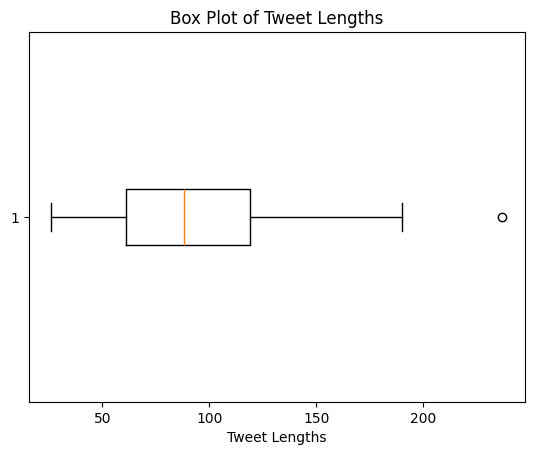

Highest Reasonable Value: 190.0


In [159]:
#compare lengths of tweets in training
train_df["tweetLength"] = train_df["tweetText"].apply(len)

bp = plt.boxplot(train_df["tweetLength"], vert=False)

#use right whisker of box plot to get highest reasonable value
max_legit_value = bp["whiskers"][1].get_data()[0][1]

plt.title("Box Plot of Tweet Lengths")
plt.xlabel("Tweet Lengths")
plt.show()

print(f"Highest Reasonable Value: {max_legit_value}")

In [162]:
#longest tweet in training
longest_tweet = train_df['tweetText'].loc[train_df['tweetText'].str.len().idxmax()]

print(longest_tweet)
print(f"Length: {len(longest_tweet)}")

#tweet looks valid


This can't be real...RT @ropgrady: \355\240\275\355\270\263\355\240\275\355\270\263\355\240\275\355\270\263 #wtf #hurricane #sandy #nyc #statueofliberty #waves \355\240\274\355\274\212\355\240\275\355\267\275⚡☔ @ NYC http://t.co/CiWRW36n
Length: 237


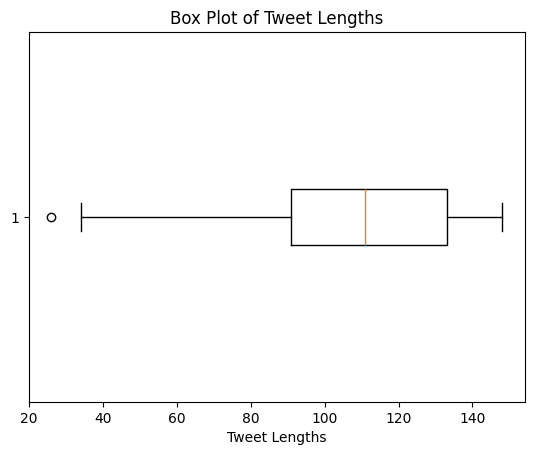

Highest Reasonable Value: 148.0


In [161]:
#compare lengths of tweets in test set
test_df["tweetLength"] = test_df["tweetText"].apply(len)

bp = plt.boxplot(test_df["tweetLength"], vert=False)

#use right whisker of box plot to get highest reasonable value
max_legit_value = bp["whiskers"][1].get_data()[0][1]

plt.title("Box Plot of Tweet Lengths")
plt.xlabel("Tweet Lengths")
plt.show()

print(f"Highest Reasonable Value: {max_legit_value}")

In [164]:
#longest tweet in testing
longest_tweet = test_df['tweetText'].loc[test_df['tweetText'].str.len().idxmax()]

print(longest_tweet)
print(f"Length: {len(longest_tweet)}")

#tweet looks valid

2&amp;half years old sister held&amp; comforted by her 4 years old brother in #Nepal. #NepalEarthquake #HelpNepal #love #kids http://t.co/7cHW0Giz2v
Length: 148


In [165]:
#number of different features in tweets + language

#language
print("Assigning language...")
train_df['language'] = train_df['tweetText'].swifter.apply(detect_language)
test_df['language'] = test_df['tweetText'].swifter.apply(detect_language)


#hastags
train_df["hashtags"] = train_df["tweetText"].str.count('#')
test_df["hashtags"] = test_df["tweetText"].str.count('#')
print("Counted hashes")

#links
train_df["urls"] = train_df["tweetText"].str.count(r'http\S+|\\\/\S+')
test_df["urls"] = test_df["tweetText"].str.count(r'http\S+|\\\/\S+')
print("Counted URLs")

#emojis
print("Counting emojis...")
train_df["emojis"] = train_df["tweetText"].swifter.apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA]))
test_df["emojis"] = test_df["tweetText"].swifter.apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA]))


#retweets
train_df["retweets"] = train_df["tweetText"].str.count(" RT ")
test_df["retweets"] = test_df["tweetText"].str.count(" RT ")
print("Counted retweets")


#modified
train_df["modified"] = train_df["tweetText"].str.count(" MT ")
test_df["modified"] = test_df["tweetText"].str.count(" MT ")
print("Counted modified tweets")


#usernames
train_df["usernames"] = train_df["tweetText"].str.count(r'@\w+')
test_df["usernames"] = test_df["tweetText"].str.count(r'@\w+')
print("Counted usernames")


Assigning language...


Pandas Apply: 100%|██████████| 3781/3781 [00:12<00:00, 311.43it/s]


Counted hashes
Counted URLs
Counting emojis...


Pandas Apply: 100%|██████████| 3781/3781 [00:00<00:00, 175249.34it/s]


Counted retweets
Counted modified tweets
Counted usernames


Text(0.5, 1.0, 'Length of Fake/Real Tweets in Training Data')

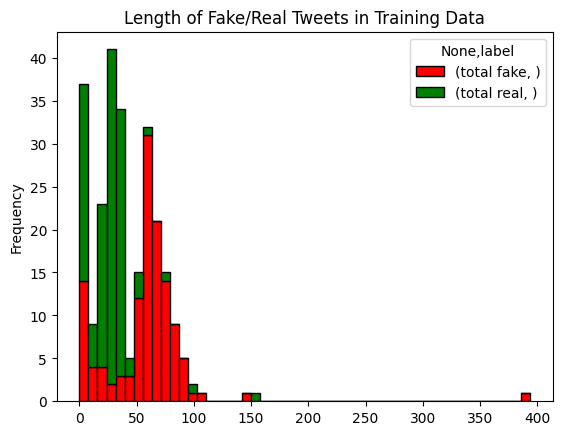

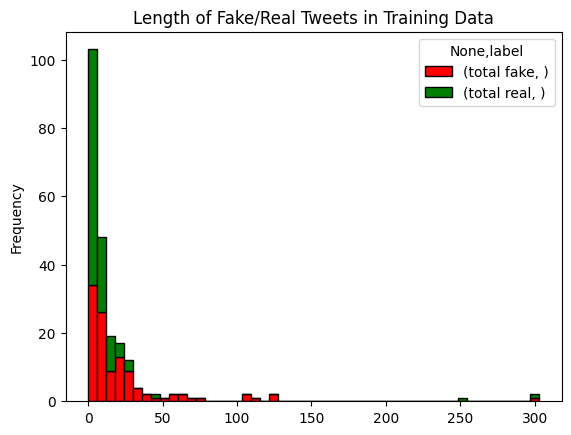

In [147]:
#comparing lengths of tweets vs label

#train
chart_data = train_df[["tweetId", "tweetLength", "label"]].groupby(["tweetLength", "label"], as_index=False).count().pivot(index='tweetLength', columns=["label"]).fillna(0).rename(columns={"tweetId": "count"})
total = chart_data['count']['fake'] + chart_data['count']['real']
chart_data['total fake'] = chart_data['count']['fake'] 
chart_data['total real'] = chart_data['count']['real'] 
ax = chart_data[['total fake', 'total real']].plot.hist(bins=50, rot=0, stacked=True, color=['red','green'], edgecolor='black')
ax.set_title("Length of Fake/Real Tweets in Training Data")

#test
chart_data = test_df[["tweetId", "tweetLength", "label"]].groupby(["tweetLength", "label"], as_index=False).count().pivot(index='tweetLength', columns=["label"]).fillna(0).rename(columns={"tweetId": "count"})
total = chart_data['count']['fake'] + chart_data['count']['real']
chart_data['total fake'] = chart_data['count']['fake'] 
chart_data['total real'] = chart_data['count']['real'] 
ax = chart_data[['total fake', 'total real']].plot.hist(bins=50, rot=0, stacked=True, color=['red','green'], edgecolor='black')
ax.set_title("Length of Fake/Real Tweets in Training Data")

In [135]:
#function to plot bar charts comparing attribute with label

def create_bar_against_label(column, percentage_flag, total_flag):

    #counting attributes for training and testing
    train_chart_data = train_df[["tweetId", column, "label"]].groupby([column, "label"], as_index=False).count().pivot(index=column, columns=["label"]).fillna(0).rename(columns={"tweetId": "count"})
    train_total = train_chart_data['count']['fake'] + train_chart_data['count']['real']

    test_chart_data = test_df[["tweetId", column, "label"]].groupby([column, "label"], as_index=False).count().pivot(index=column, columns=["label"]).fillna(0).rename(columns={"tweetId": "count"})
    test_total = test_chart_data['count']['fake'] + test_chart_data['count']['real']

    if percentage_flag == True:
        
        #plot percentage for training
        train_chart_data['percent fake'] = (train_chart_data['count']['fake'] / train_total) * 100
        train_chart_data['percent real'] = (train_chart_data['count']['real'] / train_total) * 100
        ax = train_chart_data[['percent fake', 'percent real']].plot.bar(rot=0, stacked=True, color=['red','green'])
        ax.set_title(f"Real-to-Fake Ratio of {column} in Training")

        #pllot percentage for test
        test_chart_data['percent fake'] = (test_chart_data['count']['fake'] / test_total) * 100
        test_chart_data['percent real'] = (test_chart_data['count']['real'] / test_total) * 100
        ax = test_chart_data[['percent fake', 'percent real']].plot.bar(rot=0, stacked=True, color=['red','green'])
        ax.set_title(f"Real-to-Fake Ratio of {column} in Test")
    


    if total_flag == True: 
     
        #plot count for training
        train_chart_data['total fake'] = train_chart_data['count']['fake'] 
        train_chart_data['total real'] = train_chart_data['count']['real'] 
        ax = train_chart_data[['total fake', 'total real']].plot.bar(rot=0, stacked=True, color=['red','green'])
        ax.set_title(f"Real and Fake count for {column} in Training")   

        #plot count for test
        test_chart_data['total fake'] = test_chart_data['count']['fake'] 
        test_chart_data['total real'] = test_chart_data['count']['real'] 
        ax = test_chart_data[['total fake', 'total real']].plot.bar(rot=0, stacked=True, color=['red','green'])
        ax.set_title(f"Real and Fake count for {column} in Test")

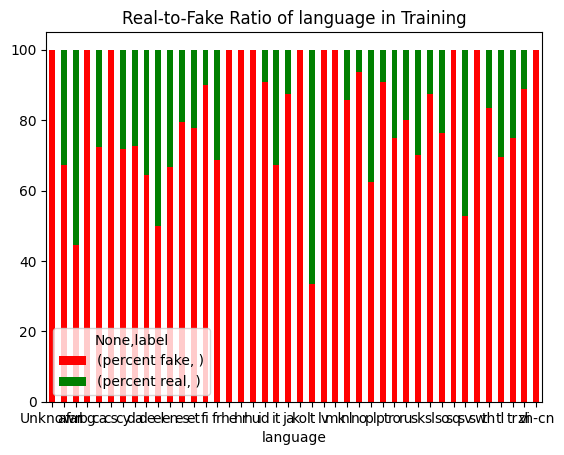

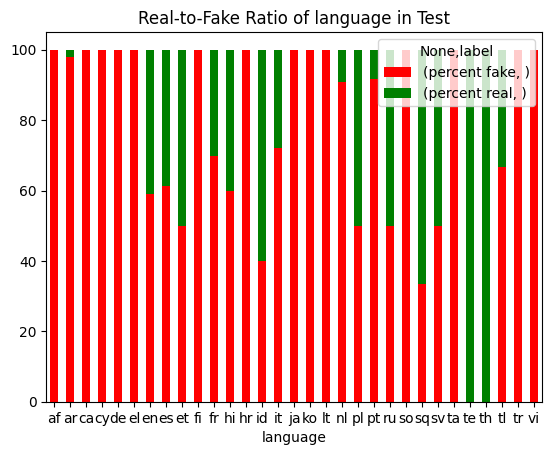

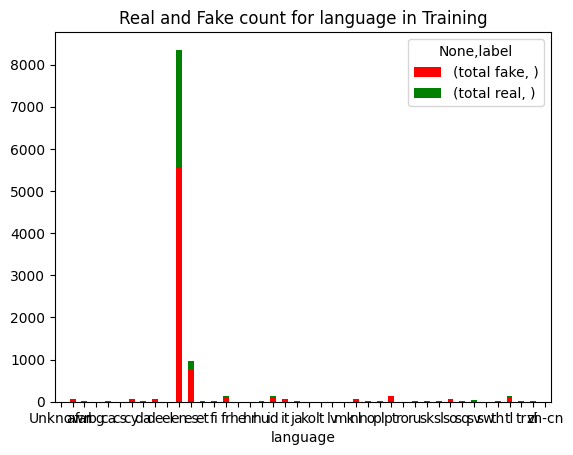

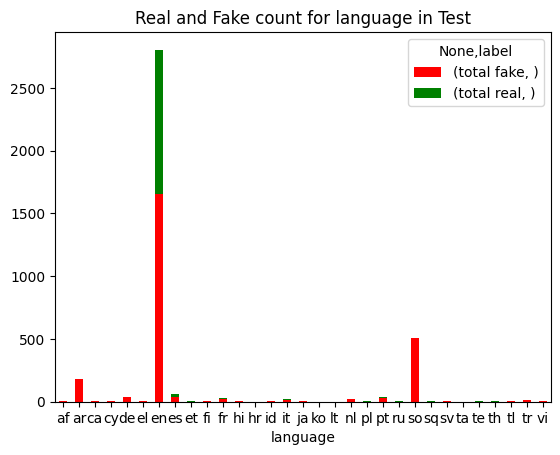

In [136]:
#comparing tweet language vs label
create_bar_against_label("language", True, True)

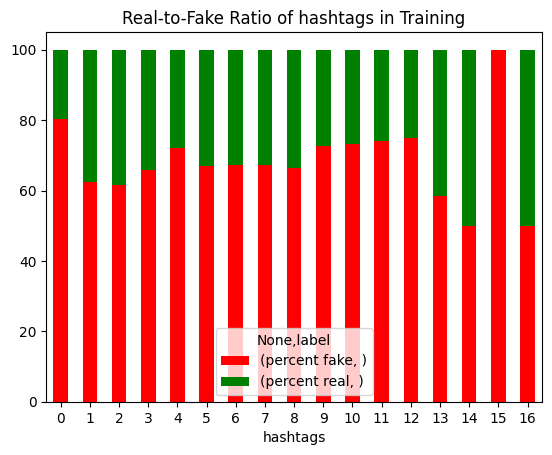

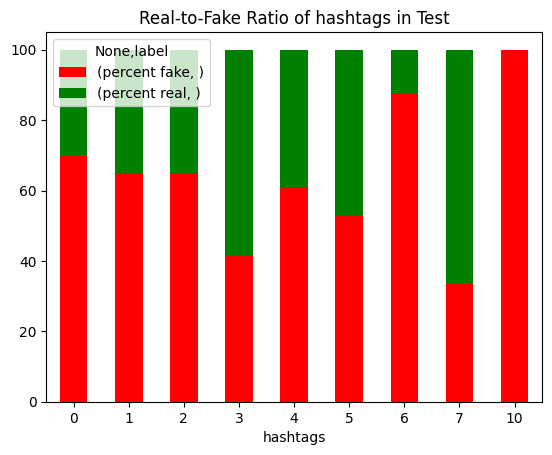

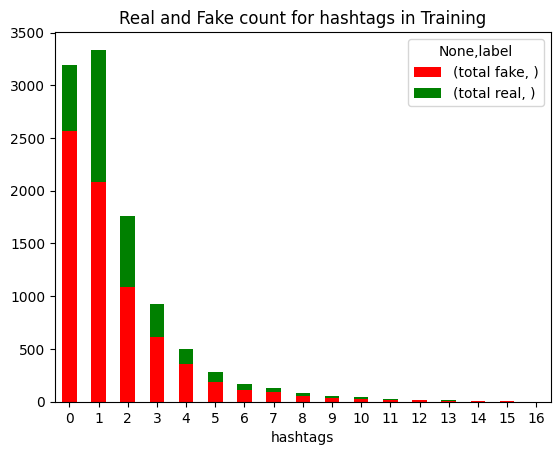

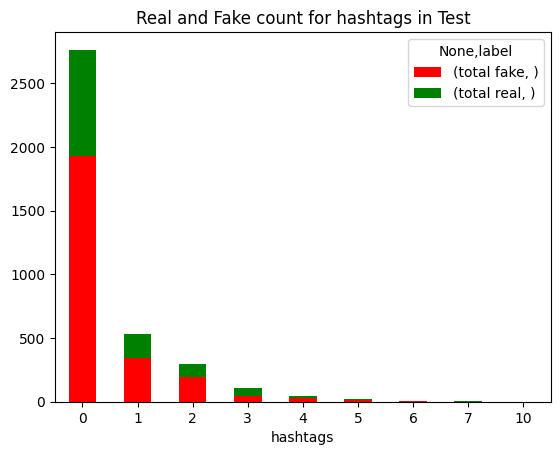

In [137]:
#comparing hashtags vs label
create_bar_against_label("hashtags", True, True)

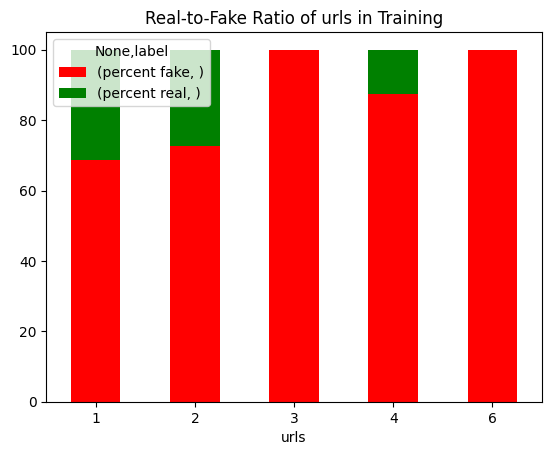

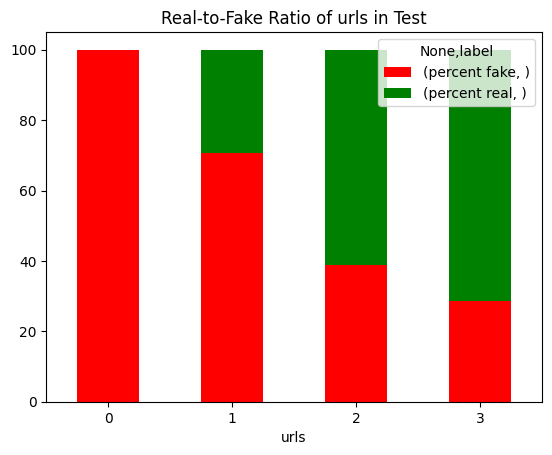

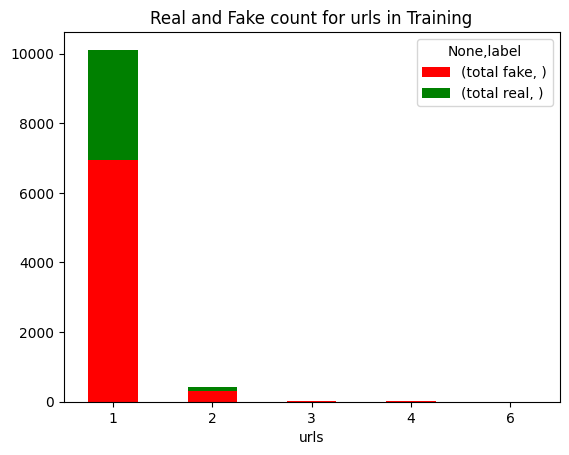

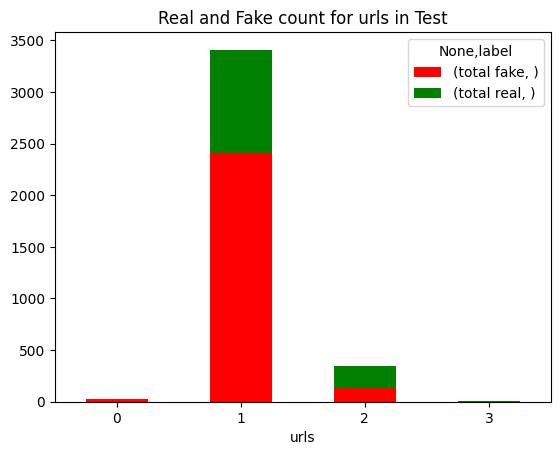

In [138]:
#comparing urls vs label
create_bar_against_label("urls", True, True)

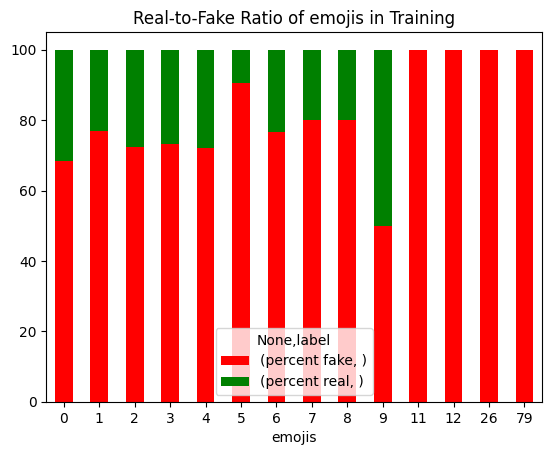

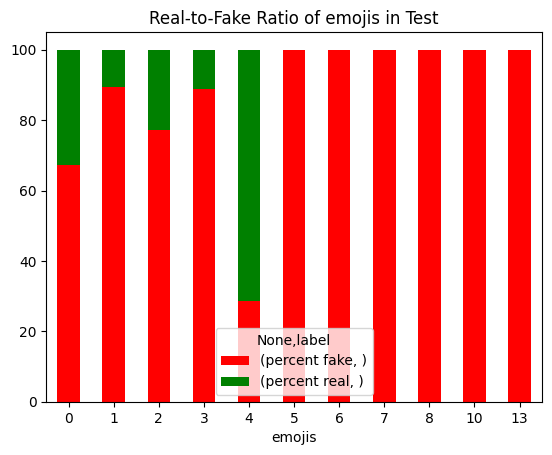

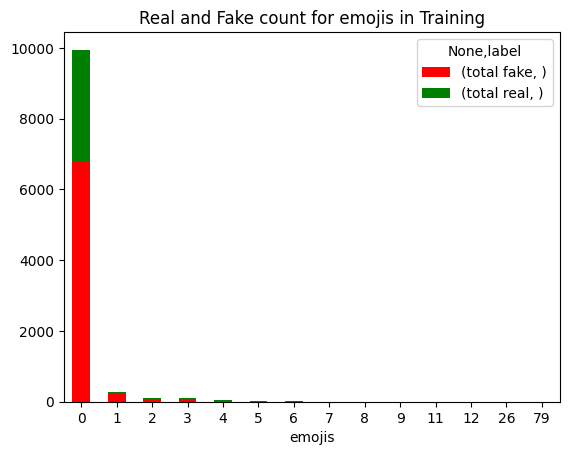

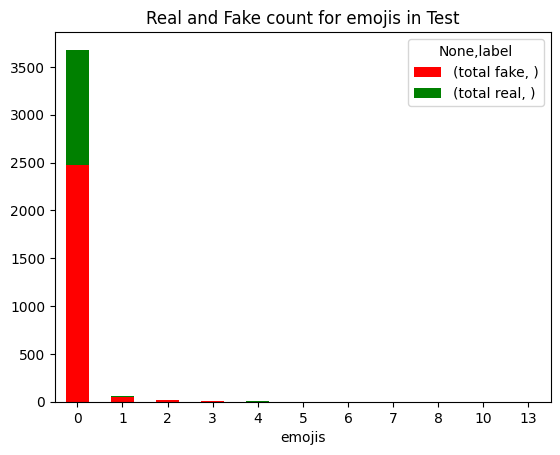

In [139]:
#comparing emojis vs label 
create_bar_against_label("emojis", True, True)

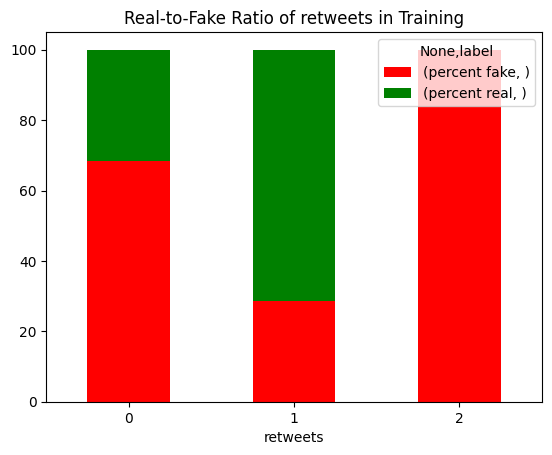

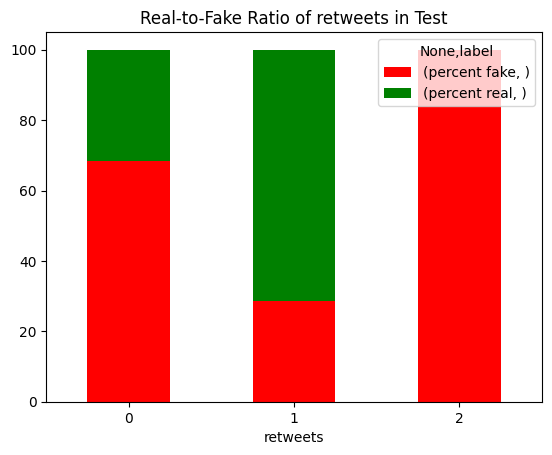

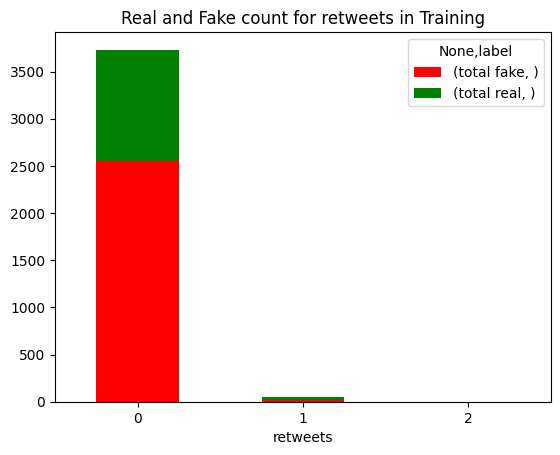

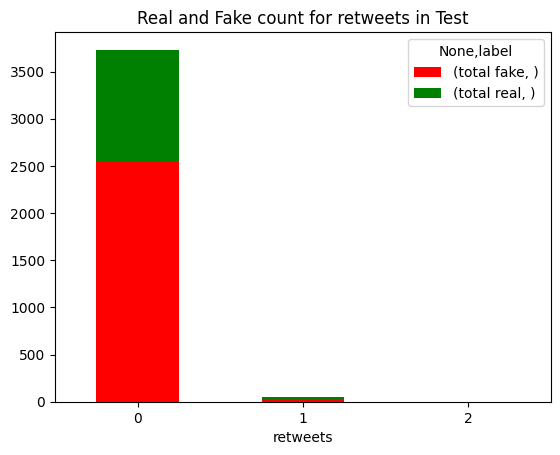

In [128]:
#comparing retweets vs label
create_bar_against_label("retweets", True, True)


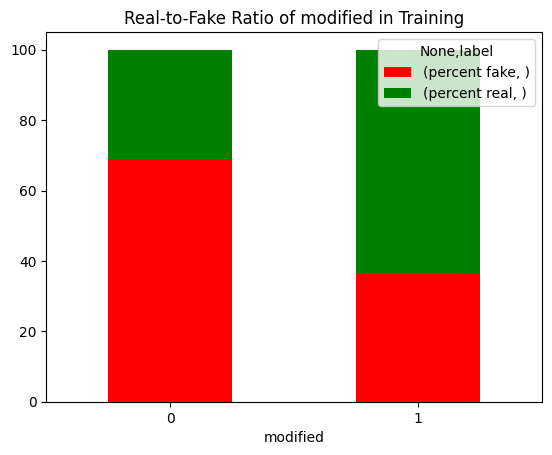

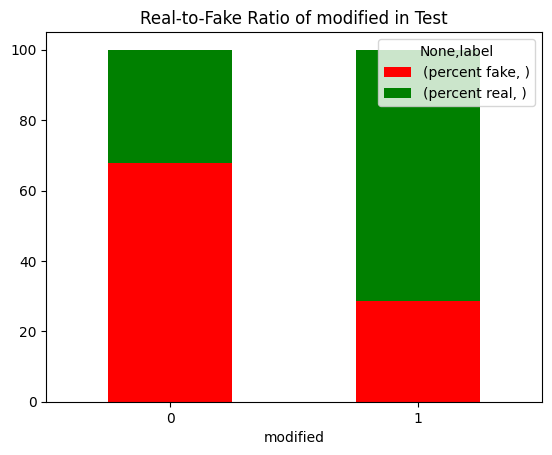

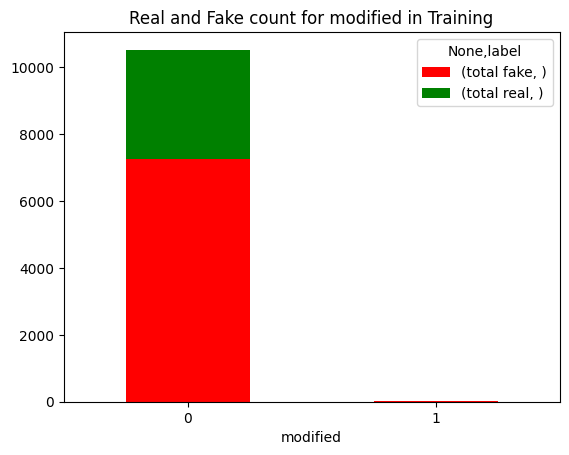

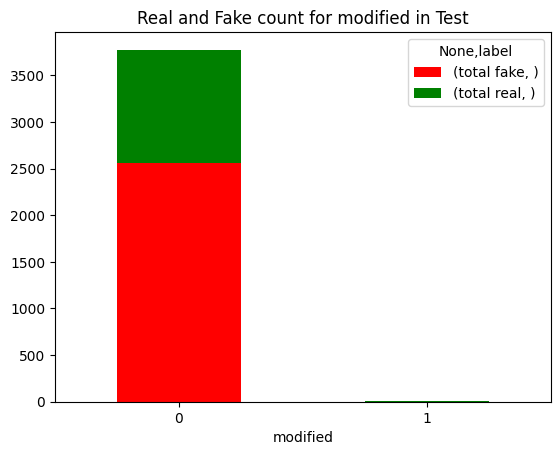

In [140]:
#comparing modified tweets vs label
create_bar_against_label("modified", True, True)

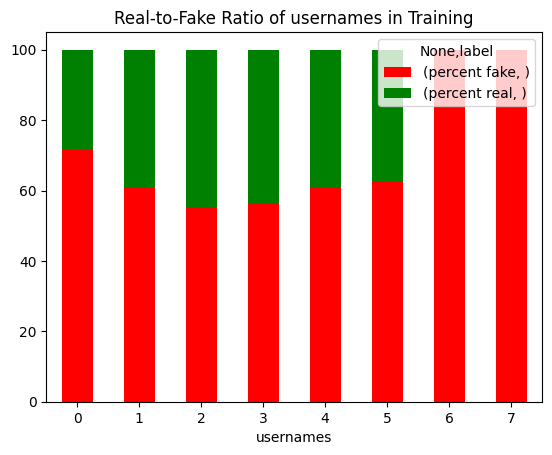

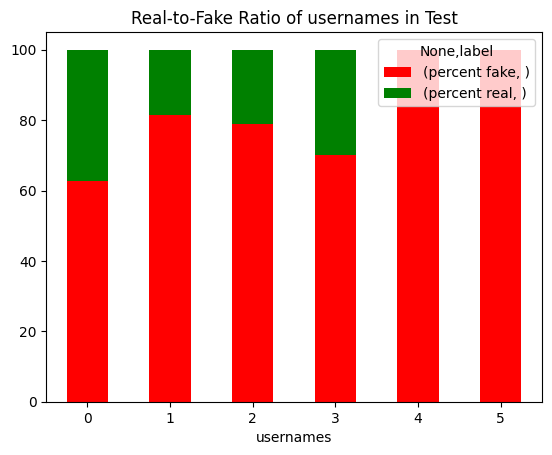

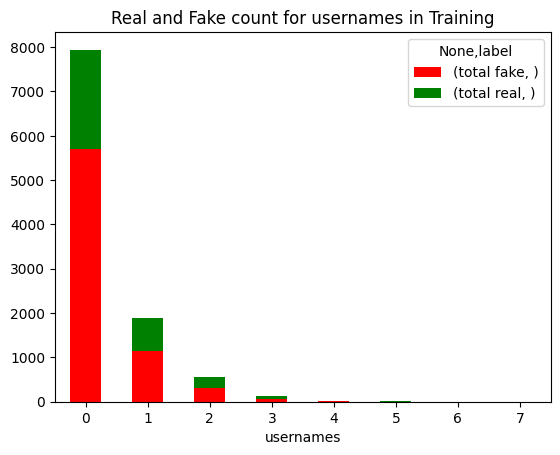

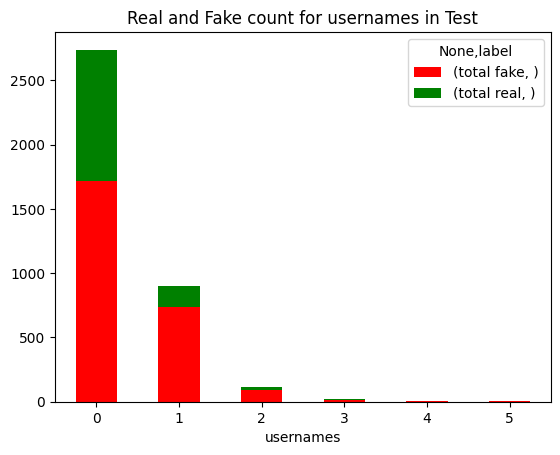

In [141]:
#comparing usernames tweets vs label
create_bar_against_label("usernames", True, True)

# Data Preprocessing

cleanText - removes urls, removes usernames, removes punctuation, normalises whitesapace, removes stopwords, lemmatises, lowers the case

smartCleanText - cleanText + POS and NER Tagging

tweetInformation - concatenates following tweet information into string:

- language 
- number of hashtags 
- number of urls
- number of emojis
- number of retweets
- number of modified tweets
- number of usernames
- tweet length 
- timestamp (month and year)

Different combinations of these preprocesses will be used while optimising pipelines

Duplicates will also be removed from training data


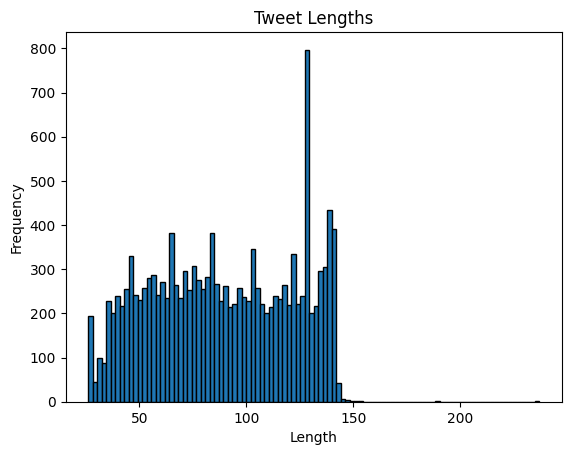

In [168]:
#NOT NEEDED
#removing 15 outliers containing multiple tweets (tweets longer than 237)
train_df = train_df[train_df["tweetLength"] < 238]

#new distribution of tweet lengths
plt.hist(train_df["tweetLength"], bins=100, edgecolor='black')

plt.title("Tweet Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

#top 10 new longest tweets
top_indices = train_df["tweetLength"].nlargest(10).index
longest_tweets = train_df.loc[top_indices, "tweetText"]




In [169]:
#Clean tweet text by removing unnecessary noise
#experiment with for best performance (some processes achieve similiar things)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

sw = nltk.corpus.stopwords.words()
lemmatiser = WordNetLemmatizer()

#two functions to preprocess data
#smartClean includes POS and NER Tagging whereas as regular cleanText doesn't
#will both be tested in pipeline configurations

def cleanText(text):
    
    #remove URLs
    text = re.sub(r'http\S+|\\\/\S+', ' ', text)

    #remove usernames 
    text = re.sub(r'@\w*', " ", text)

    #remove punctuation
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)

    #tokenise
    words = word_tokenize(text)

    #remove stopwords 
    words = [word for word in words if word.lower() not in sw]

    #lemmatise
    words = list(map(lemmatiser.lemmatize, words))  

    text = ' '.join(words)
    ##lowercase text
    text = text.lower()  

    return text

def smartCleanText(text):
    
    #remove URLs
    text = re.sub(r'http\S+|\\\/\S+', ' ', text)

    #remove usernames 
    text = re.sub(r'@\w*', " ", text)

    #remove punctuation
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)

    #tokenise
    words = word_tokenize(text)

    #remove stopwords 
    words = [word for word in words if word.lower() not in sw]

    #lemmatise
    words = list(map(lemmatiser.lemmatize, words))

    #ne chunks and pos tagging
    text = str(nltk.ne_chunk(nltk.pos_tag(words)))

    #clean tree
    text = text.replace("\n", "")
    text = text.replace("(S ", "")
    text = text.replace("/", " ")
    text = text.replace("(", "")
    text = text.replace(")", "")

    ##lowercase text
    text = text.lower()

    #normalise whitespace 
    text = re.sub(r'\s+', ' ', text)
    
    return text


#apply cleantext
train_df['smartCleanText'] = train_df['tweetText'].swifter.apply(smartCleanText)
test_df['smartCleanText'] = test_df['tweetText'].swifter.apply(smartCleanText)

train_df['cleanText'] = train_df['tweetText'].swifter.apply(cleanText)
test_df['cleanText'] = test_df['tweetText'].swifter.apply(cleanText)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
Pandas Apply: 100%|██████████| 3781/3781 [00:03<00:00, 1066.65it/s]


In [170]:
#add tweets stats column which can be added when training which concatenates information about the tweet with tags that can be recognised by the algorithm
train_df["tweetInformation"] = "lng_" + train_df["language"].astype(str) + \
                               " htgs_" + train_df["hashtags"].astype(str) + \
                               " urls_" + train_df["urls"].astype(str) + \
                               " emjs_" + train_df["emojis"].astype(str) + \
                               " rts_" + train_df["retweets"].astype(str) + \
                               " mts_" + train_df["modified"].astype(str) + \
                               " usrs_" + train_df["usernames"].astype(str) + \
                               " len_" + train_df["tweetLength"].astype(str) + \
                               " " + train_df["timestamp"]  

test_df["tweetInformation"] = "lng_" + test_df["language"].astype(str) + \
                               " htgs_" + test_df["hashtags"].astype(str) + \
                               " urls_" + test_df["urls"].astype(str) + \
                               " emjs_" + test_df["emojis"].astype(str) + \
                               " rts_" + test_df["retweets"].astype(str) + \
                               " mts_" + test_df["modified"].astype(str) + \
                               " usrs_" + test_df["usernames"].astype(str) + \
                               " len_" + test_df["tweetLength"].astype(str) + \
                               " " + test_df["timestamp"]     

In [171]:
#remove duplicates
print("cleanText") 
print(train_df["cleanText"].duplicated().sum())
train_df.drop_duplicates(subset=["cleanText"], keep="first", inplace=True)
print(train_df["cleanText"].duplicated().sum())

print("\nSmartCleanText")
print(train_df["smartCleanText"].duplicated().sum())
train_df.drop_duplicates(subset=["smartCleanText"], keep="first", inplace=True)
print(train_df["smartCleanText"].duplicated().sum())


cleanText
3939
0

SmartCleanText
0
0


Longest Tweet:
rt bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls
Length: 110


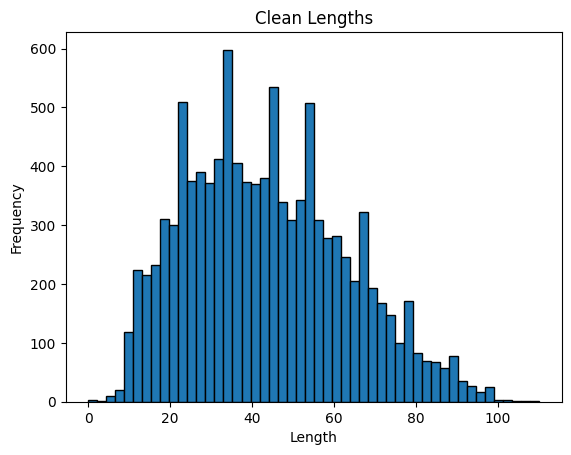

In [172]:
#lengths of cleaned text 
train_df["cleanLength"] = train_df["cleanText"].apply(len)

top_indices = train_df["cleanLength"].nlargest(16).index
longest_tweets = train_df.loc[top_indices, "cleanText"]

print(f"Longest Tweet:\n{longest_tweets.values[0]}\nLength: {len(longest_tweets.values[0])}")

#new distribution of cleaned lengths
plt.hist(train_df["cleanLength"], bins=50, edgecolor='black')

plt.title("Clean Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [173]:
#train_df.head(20)
display(train_df)

,tweetId,tweetText,userId,imageId,username,timestamp,label,tweetLength,language,hashtags,urls,emojis,retweets,modified,usernames,smartCleanText,cleanText,tweetInformation,cleanLength
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Oct 2012,fake,134,es,1,1,0,0,0,0,acuerdan jj cula nn despu nn ana nn recuerda ...,acuerdan cula despu ana recuerda pasando hurac...,lng_es htgs_1 urls_1 emjs_0 rts_0 mts_0 usrs_0...,52
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Oct 2012,fake,133,es,0,1,0,0,0,1,person miren nnp person sandy nnp ny nnp trem...,miren sandy ny tremenda imagen hurac parece in...,lng_es htgs_0 urls_1 emjs_0 rts_0 mts_0 usrs_1...,65
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Oct 2012,fake,116,es,2,1,0,0,0,0,gpe buena nnp foto nn person hurac nnp sandy ...,buena foto hurac sandy recuerda cula independe...,lng_es htgs_2 urls_1 emjs_0 rts_0 mts_0 usrs_0...,59
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Oct 2012,fake,46,en,2,1,0,0,0,0,scary jj shit vbd hurricane nn ny nnp,scary shit hurricane ny,lng_en htgs_2 urls_1 emjs_0 rts_0 mts_0 usrs_0...,23
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Oct 2012,fake,89,en,4,1,1,0,0,0,fave jj place nn world nn nyc nn hurricane nn...,fave place world nyc hurricane sandy statueofl...,lng_en htgs_4 urls_1 emjs_1 rts_0 mts_0 usrs_0...,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Mar 2014,fake,71,en,0,2,0,0,0,1,slap nn organization tweetdeck nnp pigfish nnp,slap tweetdeck pigfish,lng_en htgs_0 urls_2 emjs_0 rts_0 mts_0 usrs_1...,22
14479,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mar 2014,fake,124,en,0,2,0,0,0,0,species nns person fish nnp found vbd person ...,species fish found brazil photoshop,lng_en htgs_0 urls_2 emjs_0 rts_0 mts_0 usrs_0...,35
14480,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mar 2014,fake,57,en,1,2,0,0,0,0,call nn organization pigfish nn,call pigfish,lng_en htgs_1 urls_2 emjs_0 rts_0 mts_0 usrs_0...,12
14481,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Mar 2014,fake,81,it,0,2,0,0,0,0,gpe pigfish jj dopo nn pescecane nn pesce nn m...,pigfish dopo pescecane pesce maiale,lng_it htgs_0 urls_2 emjs_0 rts_0 mts_0 usrs_0...,35


In [174]:
display(test_df)

,tweetId,tweetText,userId,imageId,username,timestamp,label,tweetLength,language,hashtags,urls,emojis,retweets,modified,usernames,smartCleanText,cleanText,tweetInformation
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Mar 2015,fake,65,en,0,1,0,1,0,1,kereeen jj rt nnp eclipse nnp,kereeen rt eclipse,lng_en htgs_0 urls_1 emjs_0 rts_1 mts_0 usrs_1...
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Mar 2015,fake,79,en,0,1,0,1,0,1,absolutely rb beautiful jj rt nnp eclipse nnp,absolutely beautiful rt eclipse,lng_en htgs_0 urls_1 emjs_0 rts_1 mts_0 usrs_1...
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Mar 2015,fake,84,en,0,1,0,0,0,1,person eclipse nnp wow nnp amazing vbg,eclipse wow amazing,lng_en htgs_0 urls_1 emjs_0 rts_0 mts_0 usrs_1...
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Mar 2015,fake,43,en,0,1,0,0,0,0,gpe eclipse nn,eclipse,lng_en htgs_0 urls_1 emjs_0 rts_0 mts_0 usrs_0...
4,578975333841551360,"""@ebonfigli: Éclipse vue de l'ISS... Autre cho...",1150728872,eclipse_01,Epimethee_,Mar 2015,fake,117,fr,0,1,1,0,0,1,clipse nn vue nn person autre nnp chose vbd c...,clipse vue autre chose cr ation divine limite,lng_fr htgs_0 urls_1 emjs_1 rts_0 mts_0 usrs_1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Mar 2015,fake,139,fr,1,1,0,0,0,1,pr nn sentateur nn organization zdf nnp confe...,pr sentateur zdf confesse avoir truqu doigt va...,lng_fr htgs_1 urls_1 emjs_0 rts_0 mts_0 usrs_1...
3777,578433646597656576,"Oh les kleine menteurs ""@CorineBarella: Un pré...",27575883,varoufakis_1,damomarc,Mar 2015,fake,135,fr,0,1,0,0,0,1,kleine nn menteurs nns pr vbp sentateur jj or...,kleine menteurs pr sentateur zdf confesse avoi...,lng_fr htgs_0 urls_1 emjs_0 rts_0 mts_0 usrs_1...
3778,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Mar 2015,fake,111,es,0,1,0,0,0,0,programa nn organization zdf nnp confirman nn...,programa zdf confirman video varoufakis montaje,lng_es htgs_0 urls_1 emjs_0 rts_0 mts_0 usrs_0...
3779,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Mar 2015,fake,122,de,0,1,2,0,0,0,fast nnp person mittag nnp riesen nnp verwirr...,fast mittag riesen verwirrung varoufakis video...,lng_de htgs_0 urls_1 emjs_2 rts_0 mts_0 usrs_0...


# Pipeline Design and Training

In [191]:
#import relevant sklearn modules
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Different feature selection methods to be tested

bow = CountVectorizer()

ngram = CountVectorizer(ngram_range=(1,1)) #adjustable parameter

tfidf = TfidfVectorizer()

#different dimension reduction methods to be tested
svd = TruncatedSVD(n_components=100)

nmf = NMF(n_components=100)


In [63]:
#pipeline 1 using Multinomial Naive Bayes
pipeline_1 = mnb_pipeline = Pipeline([
    ('fs', tfidf),
    #('dr', dr),
    ('mnb', MultinomialNB(alpha=1))
])

#define training data
training_data_1 = train_df["smartCleanText"] + " " + train_df["tweetInformation"]

#training on entire training set
pipeline_1.fit(training_data_1, train_df["label"])

#define test data
test_data_1 = test_df["smartCleanText"] + " " + test_df["tweetInformation"]

#predicting on test set
pred_test_1 = pipeline_1.predict(test_data_1)

In [176]:
#pipeline_2 using Stochastic Gradient Descent
pipeline_2 = Pipeline([
    ('fs', tfidf),
    #('dr', dr),
    ('sgd', SGDClassifier(loss='epsilon_insensitive', penalty='l2', random_state=42, max_iter=2000, alpha=1e-4))
])

#define training data
training_data_2 = train_df["cleanText"] + " " + train_df["tweetInformation"]

#training on entire training set
pipeline_2.fit(training_data_2, train_df["label"])

#define test data
test_data_2 = test_df["cleanText"] + " " + test_df["tweetInformation"]

#predicting on test set
pred_test_2 = pipeline_2.predict(test_data_2)

In [ ]:
##USED for quick testing using training validation set, not used in final results
##splitting training set into train and val
#
#
##x = features, y = labels
#X_train, X_val, y_train, y_val = train_test_split(train_df["cleanText"], train_df["label"], test_size=0.2, random_state=69)
#
##training pipeline_1 
#pipeline_1.fit(X_train, y_train)
#
##evaluating pipeline_1
#accuracy_1 = pipeline_1.score(X_val, y_val)
#print("MNB accuracy:   %0.3f" % accuracy_1)
#
##training pipeline_2 
#pipeline_2.fit(X_train, y_train)
#
##evaluating pipeline_1
#accuracy_2 = pipeline_2.score(X_val, y_val)
#print("SGD accuracy:   %0.3f" % accuracy_2)


# Evaluation

MNB classification report:

              precision    recall  f1-score   support

        fake       0.88      1.00      0.94      2564
        real       1.00      0.71      0.83      1217

    accuracy                           0.91      3781
   macro avg       0.94      0.86      0.88      3781
weighted avg       0.92      0.91      0.90      3781


SGD classification report:

              precision    recall  f1-score   support

        fake       0.90      0.93      0.91      2564
        real       0.84      0.78      0.81      1217

    accuracy                           0.88      3781
   macro avg       0.87      0.86      0.86      3781
weighted avg       0.88      0.88      0.88      3781



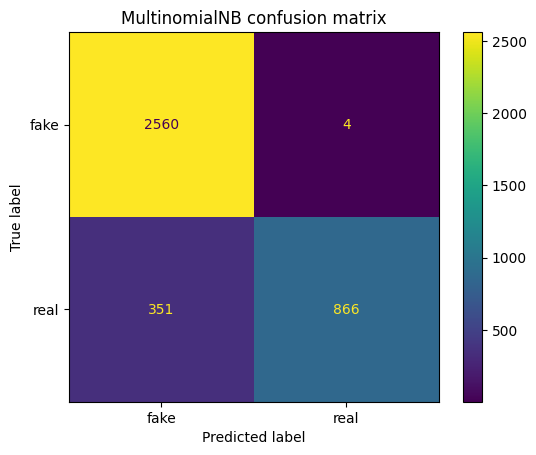

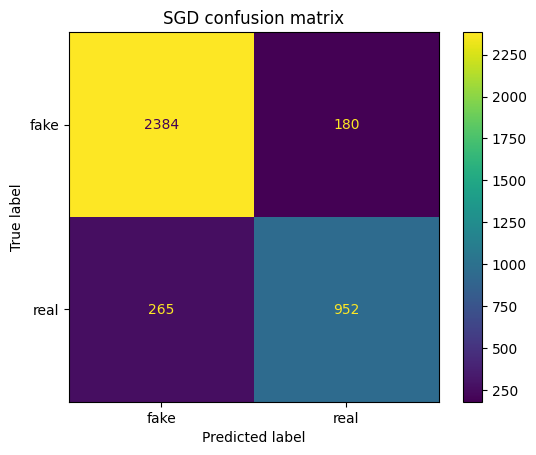

In [192]:
#evaluating pipeline performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

#Classification Report 1

report_1 = classification_report(test_df['label'], pred_test_1)
print("MNB classification report:\n")
print(report_1)


#Classification Report 2
report_2 = classification_report(test_df['label'], pred_test_2)
print("\nSGD classification report:\n")
print(report_2)

#confusion matrix for pipeline_1

cm_1 = confusion_matrix(test_df['label'], pred_test_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipeline_1.classes_).plot()

plt.title("MultinomialNB confusion matrix")
plt.show()

#confusion matrix for pipeline_2

cm_2 = confusion_matrix(test_df['label'], pred_test_2)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipeline_2.classes_).plot()

plt.title("SGD confusion matrix")
plt.show()
